In [1462]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Audio
import scipy
from scipy.signal import find_peaks
from scipy.signal import butter, sosfilt, sosfreqz
from scipy.integrate import simps
from scipy.io.wavfile import write
import bisect
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
from scipy.fftpack import dct
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, f1_score
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
import sounddevice as sd
import wavio as wv
from datetime import datetime
import threading
import time
from time import sleep
from statistics import stdev
from sklearn.datasets import make_classification
from sklearn.feature_selection import mutual_info_classif
import norm
from scipy.signal import lfilter
from scipy.signal import find_peaks
from scipy.stats import probplot

# Data Preparation

## Data Loading

In [1463]:
# Extracts timestamps from a .txt file
# Each line in the file contains a start and finish time separated by a tab.

def get_real_timestamps(audio_timestamp_file):
    
    """
    Parses a .txt file containing timestamp information.
    
    Parameters:
        audio_timestamp_file (str): Path to the .txt file.
    
    Returns:
        list: List of tuples, each containing start and finish times.
    """
    
    timestamps = []

    with open(audio_timestamp_file, "r") as f:
        for line in f:
            line = line.strip()
            if line:
                start, end = map(float, line.split("\t"))
                timestamps.append((start, end))

    return timestamps

In [1464]:
import os
import librosa

# Function to load audio data along with corresponding timestamps and labels.
def load_data(audio_dir, timestamp_dir, label, sr=48000):
    
    """
    Loads audio data from WAV files along with corresponding timestamps and labels.

    Parameters:
        audio_dir (str): Directory containing audio WAV files.
        timestamp_dir (str): Directory containing timestamp text files.
        label (str): Label to assign to the loaded data.
        sr (int): Sample rate of the audio files (default is 48000).

    Returns:
        tuple: A tuple containing lists of loaded audio data, timestamps, and labels.
    """
    
    audio_files = [file for file in os.listdir(audio_dir) if file.endswith('.wav')]
    timestamp_files = [file for file in os.listdir(timestamp_dir) if file.endswith('.txt')]
    
    
    audios = []
    timestamps = []
    labels = []
    
    for audio_file in audio_files:
    
        try:
            
            base_name = os.path.splitext(audio_file)[0]
            timestamp_file = base_name + '-label.txt'
            
            if timestamp_file not in timestamp_files:
                raise ValueError(f"No corresponding timestamp file found for {audio_file}")
                
            audio_path = os.path.join(audio_dir, audio_file)
            timestamp_path = os.path.join(timestamp_dir, timestamp_file)
            
            # Adding timestamps to the list
            real_timestamps = get_real_timestamps(timestamp_path)

            # Loading audio file
            data, sample_rate = librosa.load(audio_path, sr=sr, mono=True)
            data = librosa.resample(data, orig_sr=sample_rate, target_sr=sr)

            audios.append(data)
            timestamps.append(real_timestamps)
            labels.append(label)

        except Exception as e:
            print(f"Error processing {audio_file}: {e}")
            continue

    
    return audios, timestamps, labels

In [1465]:
# Initialize an empty dictionary to store audio data along with timestamps and labels
audio_data = {'audio': [], 'timestamps': [], 'label': []}

# Define the sample rate for the audio data
sample_rate = 48000

# Load cough and non-cough audio data along with their timestamps and labels
wet_cough_data, wet_cough_timestamps, wet_cough_labels = load_data('./recordings-and-timestamps/audio-recordings/coughvid-wet-coughs/', './recordings-and-timestamps/audio-timestamps/coughvid-wet-cough-timestamps/', 'wet')
dry_cough_data, dry_cough_timestamps, dry_cough_labels = load_data('./recordings-and-timestamps/audio-recordings/coughvid-dry-coughs/', './recordings-and-timestamps/audio-timestamps/coughvid-dry-cough-timestamps/', 'dry')

audio_data['audio'].extend(wet_cough_data + dry_cough_data)
audio_data['timestamps'].extend(wet_cough_timestamps + dry_cough_timestamps)
audio_data['label'].extend(wet_cough_labels + dry_cough_labels)

Error processing wet-audio-34.wav: No corresponding timestamp file found for wet-audio-34.wav


## Data Splitting

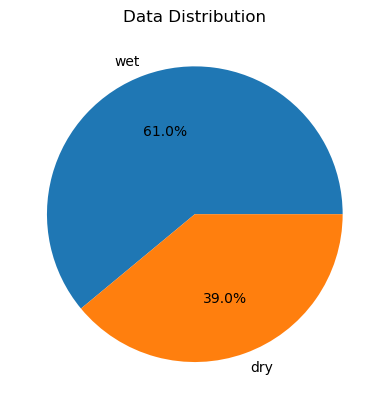

In [1466]:
# Splitting the dataset into cough and other categories for classification.
df_init = pd.DataFrame.from_dict(audio_data)

X = df_init.iloc[:,:-1]
y = df_init.iloc[:, -1]

# Splitting cough data into train and test sets
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, random_state=3, train_size=0.70)

# Data Distribution

label_counts = df_init['label'].value_counts()

fig, ax = plt.subplots()
ax.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%')
plt.title("Data Distribution")
plt.show()

## Data Normalization and Filtering

### Preprocessing Functions

In [1467]:
# Function to normalize the given data

def normalize_data(data):

    # Find the minimum and maximum values in the data
    data_min = np.min(data)
    data_max = np.max(data)

    # Normalize the data using min-max scaling
    normalized_data = (data - data_min) / (data_max - data_min)

    return normalized_data

In [1468]:
def compute_moving_average(data, window_size=15):

    """
    Computes the moving average of the input data using a specified window size.

    Parameters:
    - data (array-like): Input data to compute the moving average.
    - window_size (int, optional): Size of the moving average window. Defaults to 15.

    Returns:
    - array: Array containing the moving averages.

    Note:
    The moving average is computed using a simple convolution with a kernel of ones.
    """
    kernel = np.ones(window_size) / window_size
    moving_averages = np.convolve(data, kernel, mode='valid')
    moving_averages = np.round(moving_averages, 2)
    
    return moving_averages

In [1469]:
# This function designs a Butterworth bandpass filter and applies it to the input data.

def butter_bandpass(lowcut, highcut, fs, order=8):
    
    """
    Design a Butterworth bandpass filter.

    Parameters:
    - lowcut (float): The low cutoff frequency.
    - highcut (float): The high cutoff frequency.
    - fs (float): The sampling frequency of the signal.
    - order (int): The order of the filter (default is 8).

    Returns:
    - sos (ndarray): Second-order sections (SOS) representation of the filter.
    """

    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], analog=False, btype='band', output='sos')
    return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=8):
    
    """
    Apply a Butterworth bandpass filter to the input data.

    Parameters:
    - data (array_like): Input data to be filtered.
    - lowcut (float): The low cutoff frequency.
    - highcut (float): The high cutoff frequency.
    - fs (float): The sampling frequency of the signal.
    - order (int): The order of the filter (default is 8).

    Returns:
    - y (array_like): Filtered output data.
    """

    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sosfilt(sos, data)
    return y

In [1470]:
# Preprocesses the input data by applying a bandpass filter, computing moving average, and normalizing the data.
def preprocess_data(data):
    
    """
    Parameters:
    - data (ndarray): Input data to be preprocessed.
        
    Returns:
    - ndarray: Preprocessed data.

    Note:
    - This function applies a bandpass filter, computes the moving average, and normalizes the data.
    """

    # Apply bandpass filter to remove unwanted frequencies
    filtered_data = butter_bandpass_filter(data, lowcut=1000, highcut=4000, fs=sample_rate, order=8)

    # Compute moving average of the absolute values of the filtered data
    averaged_data = compute_moving_average(np.abs(filtered_data))

    # Normalize the data
    normalized_data = normalize_data(averaged_data)

    # Flatten the data
    flattened_data = normalized_data.flatten()

    return flattened_data

### Percentile Calculation Functions

In [1471]:
def find_percentile_points(signal):
    
        """
        Calculate the percentile points (25th, 50th, 75th, and 90th percentiles) of a signal using Fast Fourier Transform (FFT).

        Parameters:
        - signal (array_like): The input signal.
        - sample_rate (float): The sampling rate of the signal.

        Returns:
        - tuple: A tuple containing the percentile points (25th, 50th, 75th, and 90th percentiles).
        
        """
        
        # Calculate Fast Fourier Transform
        X = np.fft.fft(signal)
        X_mag = np.abs(X) / len(signal)
        freqs = np.fft.fftfreq(len(signal), d=1/sample_rate)

        # Consider only positive frequencies
        positive_freq_indices = np.where(freqs >= 0)
        freqs = freqs[positive_freq_indices]
        X_mag = X_mag[positive_freq_indices]

        # Calculate area under curve
        auc = simps(X_mag, freqs)

        # Define percentiles
        per_25 = auc * 0.25
        per_50 = auc * 0.50
        per_75 = auc * 0.75
        per_90 = auc * 0.90

        # Calculate cumulative area
        cumulative_auc = np.cumsum(X_mag)

        # Find indices for each percentile
        point_1 = np.argmax(cumulative_auc >= per_25)
        point_2 = np.argmax(cumulative_auc >= per_50)
        point_3 = np.argmax(cumulative_auc >= per_75)
        point_4 = np.argmax(cumulative_auc >= per_90)

        # Retrieve frequency points corresponding to percentiles
        per_25_result = freqs[point_1]
        per_50_result = freqs[point_2]
        per_75_result = freqs[point_3]
        per_90_result = freqs[point_4]

        return per_25_result, per_50_result, per_75_result, per_90_result

### MFCC Calculation Functions

In [1472]:
def get_mfcc_features(signal, sample_rate=48000, n_mfcc=13, delta_width=3):
    """
    Compute Mel-Frequency Cepstral Coefficients (MFCCs) and their first and second derivatives.

    Parameters:
    - signal (ndarray): Input audio signal.
    - sample_rate (int): Sampling rate of the input signal.
    - n_mfcc (int): Number of MFCC coefficients to compute.
    - delta_width (int): Width parameter for computing delta features.

    Returns:
    - tuple: A tuple containing the MFCCs, first-order derivatives, and second-order derivatives.
    """

    # Original MFCCs
    mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=n_mfcc)

    # First derivative of MFCCs
    delta_mfccs = librosa.feature.delta(mfccs, width=delta_width)

    # Second derivative of MFCCs
    delta2_mfccs = librosa.feature.delta(mfccs, order=2, width=delta_width)

    return mfccs, delta_mfccs, delta2_mfccs

### Other Feature Extraction Functions

In [1473]:
def compute_statistics(feature):
    statistics = [
        np.mean(feature),
        np.median(feature),
        np.sqrt(np.mean(np.square(feature))),
        np.max(feature),
        np.min(feature),
        np.percentile(feature, 25),
        np.percentile(feature, 75),
        scipy.stats.iqr(t),
        np.std(feature),
        scipy.stats.skew(feature),
        scipy.stats.kurtosis(feature)
    ]
    return np.array(statistics)

In [1474]:
def calculate_log_energy(signal):
    """
    Calculate the log energy of a signal.
    
    Parameters:
        signal (numpy.ndarray): Input signal
        
    Returns:
        float: Log energy of the signal
    """
    # Compute the energy of the signal
    energy = np.sum(np.square(signal))
    
    # Take the logarithm of the energy
    log_energy = np.log(energy)
    
    return log_energy

In [1475]:
def get_spectral_centroid(data):
    
    spectral_centroid = librosa.feature.spectral_centroid(y=data, sr=sample_rate)[0]
    spectral_centroid_statistics = compute_statistics(spectral_centroid)
    
    return spectral_centroid_statistics

In [1476]:
# Compute the spectral bandwidth of an audio signal.

def get_spectral_bandwidth(data):
    
    spectral_bandwidth=librosa.feature.spectral_bandwidth(y=data)[0]
    spectral_bandwidth_statistics = compute_statistics(spectral_bandwidth)
    
    return spectral_bandwidth_statistics

In [1477]:
# Compute the spectral contrast of an audio signal.

def get_spectral_contrast(data):

    spectral_contrast=librosa.feature.spectral_contrast(y=data)[0]
    spectral_contrast_statistics = compute_statistics(spectral_contrast)
    
    return spectral_contrast_statistics

In [1478]:
# Compute the spectral flatness of an audio signal.

def get_spectral_flatness(data):

    spectral_flatness=librosa.feature.spectral_flatness(y=data)[0]
    spectral_flatness_statistics = compute_statistics(spectral_flatness)
    
    return spectral_flatness_statistics

In [1479]:
# Compute the spectral rolloff of an audio signal.

def get_spectral_rolloff(data):

    spectral_rolloff=librosa.feature.spectral_rolloff(y=data)[0]
    spectral_rolloff_statistics = compute_statistics(spectral_rolloff)
    
    return spectral_rolloff_statistics

## Extracting Data Features

In [1480]:
def get_feature_dictionary(data_frame):
    
    feature_dict = {
    'percentile_25': [],
    'percentile_50': [],
    'percentile_75': [],
    'percentile_90': [],
    'mfcc': [],
    'sc': [],
    'spectral_bandwidth': [],
    'spectral_contrast': [],
    'spectral_flatness': [],
    'spectral_rolloff': [],
    'energy': [],
    'duration': [],
    'label': []
    }
    

    # Iterate through rows of training data and extract features
    for row in data_frame.values:

        extracted_data = row[0]  # Extracted audio data
        label = row[1]  # Label of the audio
        
        # Feature extraction
        per_25, per_50, per_75, per_90 = find_percentile_points(extracted_data)  # Percentile points    
        mfccs, delta_mfccs, delta2_mfccs = get_mfcc_features(extracted_data)  # MFCC features
        comprehensive_mfccs = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))  # Comprehensive MFCCs    
        comprehensive_mfccs_mean = np.mean(comprehensive_mfccs, axis=1)  # Mean of MFCC features
        
        sc = get_spectral_centroid(extracted_data)  # Spectral centroid        
        spectral_bandwidth = get_spectral_bandwidth(extracted_data) # Spectral bandwidth
        spectral_contrast = get_spectral_contrast(extracted_data)  # Spectral contrast
        spectral_flatness = get_spectral_flatness(extracted_data)  # Spectral flatness
        spectral_rolloff = get_spectral_rolloff(extracted_data)  # Spectral rolloff
        energy = calculate_log_energy(extracted_data)  # Energy
        duration = len(extracted_data) / sample_rate * 1000
        
        # Append extracted features to the dictionary
        feature_dict['percentile_25'].append(per_25)
        feature_dict['percentile_50'].append(per_50)
        feature_dict['percentile_75'].append(per_75)
        feature_dict['percentile_90'].append(per_90)
        feature_dict['mfcc'].append(comprehensive_mfccs_mean)
        feature_dict['sc'].append(sc)
        feature_dict['spectral_bandwidth'].append(spectral_bandwidth)
        feature_dict['spectral_contrast'].append(spectral_contrast)
        feature_dict['spectral_flatness'].append(spectral_flatness)
        feature_dict['spectral_rolloff'].append(spectral_rolloff)
        feature_dict['energy'].append(energy)
        feature_dict['duration'].append(duration)
        feature_dict['label'].append(label)
    
    return feature_dict

### Train Data Feature Extraction

In [1481]:
# Function to remove leading and trailing zeros from a float array

def remove_leading_trailing_zeros(array):
    
    nonzero_indices = np.where(array != 0)[0]
    if len(nonzero_indices) == 0:
        return np.array([])
    
    return array[nonzero_indices[0]:nonzero_indices[-1] + 1]

In [1482]:
# Extract Train Data

# Initialize extracted train data dictionary
extracted_train_data = {'data': [], 'label': []}

# Iterate through train data and labels
for (info, label) in zip(X_train_raw.values, y_train_raw.values):
    
    # Extract features and timestamps
    data, timestamps = info[0], info[1]
    data = remove_leading_trailing_zeros(data)

    # Preprocess data
    data = preprocess_data(data)
    
    # Extract coughs/others
    for timestamp in timestamps:
        
        start = int(timestamp[0] * sample_rate)
        finish = int(timestamp[1] * sample_rate)
        
        # Ensure start and finish are within bounds
        start = max(0, start)
        finish = min(len(data), finish)

        # Extract data within timestamps
        extracted_data = data[start:finish]
        extracted_data = remove_leading_trailing_zeros(extracted_data)


        # Append extracted data and label
        if len(extracted_data) > 0:

            extracted_train_data['data'].append(extracted_data)
            extracted_train_data['label'].append(label)

# Convert dictionary to DataFrame
df_train_extracted = pd.DataFrame.from_dict(extracted_train_data)
print(df_train_extracted)

                                                  data label
0    [0.2272727272727273, 0.2272727272727273, 0.181...   wet
1    [0.2727272727272727, 0.2727272727272727, 0.272...   wet
2    [0.03278688524590164, 0.03278688524590164, 0.0...   dry
3    [0.01639344262295082, 0.01639344262295082, 0.0...   dry
4    [0.023255813953488372, 0.023255813953488372, 0...   dry
..                                                 ...   ...
124  [0.14102564102564102, 0.15384615384615383, 0.1...   wet
125  [0.05128205128205128, 0.03846153846153846, 0.0...   wet
126  [0.16666666666666666, 0.15384615384615383, 0.1...   wet
127  [0.01282051282051282, 0.01282051282051282, 0.0...   wet
128  [0.02564102564102564, 0.02564102564102564, 0.0...   dry

[129 rows x 2 columns]


### Test Data Feature Extraction

In [1483]:
# Extract Validation Data

# Initialize extracted train data dictionary
extracted_test_data = {'data': [], 'label': []}

# Iterate through train data and labels
for (info, label) in zip(X_test_raw.values, y_test_raw.values):
    
    # Extract features and timestamps
    data, timestamps = info[0], info[1]
    data = remove_leading_trailing_zeros(data)

    # Preprocess data
    data = preprocess_data(data)
    
    # Extract coughs/others
    for timestamp in timestamps:
        
        start = int(timestamp[0] * sample_rate)
        finish = int(timestamp[1] * sample_rate)
        
        # Ensure start and finish are within bounds
        start = max(0, start)
        finish = min(len(data), finish)

        # Extract data within timestamps
        extracted_data = data[start:finish]
        extracted_data = remove_leading_trailing_zeros(extracted_data)
        
        # Append extracted data and label
        if len(extracted_data) > 0:
            
            extracted_test_data['data'].append(extracted_data)
            extracted_test_data['label'].append(label)
      
# Convert dictionary to DataFrame
df_test_extracted = pd.DataFrame.from_dict(extracted_test_data)
print(df_test_extracted)

                                                 data label
0   [0.037037037037037035, 0.037037037037037035, 0...   dry
1   [0.16666666666666666, 0.16666666666666666, 0.1...   dry
2   [0.35185185185185186, 0.37037037037037035, 0.3...   dry
3   [0.08695652173913043, 0.08695652173913043, 0.1...   wet
4   [0.17391304347826086, 0.17391304347826086, 0.1...   wet
..                                                ...   ...
69  [0.171875, 0.171875, 0.171875, 0.171875, 0.171...   dry
70  [0.28125, 0.265625, 0.234375, 0.21875000000000...   dry
71  [0.3125, 0.3125, 0.328125, 0.34375, 0.359375, ...   dry
72  [0.09375, 0.09375, 0.10937500000000001, 0.1093...   dry
73  [0.046875, 0.046875, 0.046875, 0.046875, 0.046...   dry

[74 rows x 2 columns]


In [1484]:
# Getting feature dictionaries of trianing and validation data

Audiodata_train = get_feature_dictionary(df_train_extracted)
Audiodata_test = get_feature_dictionary(df_test_extracted)

/Users/zulaldemirtas/anaconda3/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1694
  warnings.warn(


In [1485]:
df_audio_all = pd.concat([df_train_extracted, df_test_extracted])

dry_coughs = df_audio_all[df_audio_all['label'] == 'dry']
wet_coughs = df_audio_all[df_audio_all['label'] == 'wet']

dry_total_duration = 0
wet_total_duration = 0

for data in dry_coughs['data']:
    
    dry_total_duration += len(data) / sample_rate
    
for data in wet_coughs['data']:
    
    wet_total_duration += len(data) / sample_rate
    
dry_cough_duration = dry_total_duration / len(dry_coughs['label']) * 1000 # in ms
wet_cough_duration = wet_total_duration / len(wet_coughs['label']) * 1000 # in ms

print("Dry Cough Average Duration in ms: ", dry_cough_duration)
print("Wet Cough Average Duration in ms: ", wet_cough_duration)

Dry Cough Average Duration in ms:  325.39037216828484
Wet Cough Average Duration in ms:  472.78354166666657


## Train, Test and Validation Data

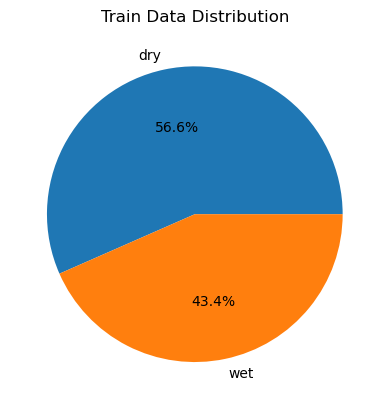

   percentile_25  percentile_50  percentile_75  percentile_90  \
0       0.000000        0.00000            0.0            0.0   
1     949.995961    16650.13329            0.0            0.0   
2    4645.492095        0.00000            0.0            0.0   
3   14114.253666        0.00000            0.0            0.0   
4     779.705204        0.00000            0.0            0.0   

                                                mfcc  \
0  [-145.96855730974713, 108.59623998336399, 6.10...   
1  [-150.80103641657914, 117.09144960731905, 7.96...   
2  [-254.5903551362074, 119.49545977284185, 10.14...   
3  [-228.13938712981692, 121.85187717990262, 8.72...   
4  [-188.69766203492023, 129.42832596170427, 29.2...   

                                                  sc  \
0  [4352.5329710973465, 4176.739311749849, 4390.8...   
1  [3723.2948642447454, 3329.962688684804, 3940.8...   
2  [3782.5697324336656, 3663.5607555045653, 3908....   
3  [3607.2781864656736, 3194.9074812955396, 3692

In [1486]:
# Train Data 

df_train = pd.DataFrame.from_dict(Audiodata_train) 
        
# Create train data

X_train = []
y_train = []

for row in df_train.values:
    
    flattened_row = []
    for item in row[:-1]:
        if isinstance(item, np.ndarray):
            flattened_row.extend(item.flatten())
        else:
            flattened_row.append(item)
        
    X_train.append(flattened_row)
    y_train.append(row[-1])
    
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)


# Data Distribution

label_counts = df_train['label'].value_counts()

fig, ax = plt.subplots()
ax.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%')
plt.title("Train Data Distribution")
plt.show()
print(df_train.head())

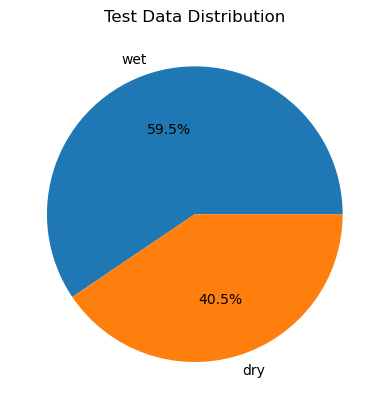

   percentile_25  percentile_50  percentile_75  percentile_90  \
0     699.661017   18500.338983            0.0            0.0   
1     989.361702       0.000000            0.0            0.0   
2     654.694249    4939.304387            0.0            0.0   
3    1037.668471   14099.758092            0.0            0.0   
4    1036.117095   22806.741858            0.0            0.0   

                                                mfcc  \
0  [-176.63086887071304, 143.75463545147724, 0.02...   
1  [-241.58534565181805, 121.50863430705137, 4.69...   
2  [-189.77975904168687, 137.27095061045185, -1.7...   
3  [-225.1465306236848, 108.51602296408056, 3.680...   
4  [-273.20396853997636, 96.54968469034907, 0.645...   

                                                  sc  \
0  [2860.991558834156, 2019.0708595546444, 3274.2...   
1  [3990.022503012832, 4195.606480095161, 4288.53...   
2  [3243.0967581752784, 2445.161330788851, 3589.0...   
3  [4440.426458921597, 4155.882729830572, 4578.6

In [1487]:
# Test Data 

df_test = pd.DataFrame.from_dict(Audiodata_test) 
        
# Create test data

X_test = []
y_test = []

for row in df_test.values:
    
    flattened_row = []
    for item in row[:-1]:
        if isinstance(item, np.ndarray):
            flattened_row.extend(item.flatten())
            
        else:
            flattened_row.append(item)
    
    X_test.append(flattened_row)
    y_test.append(row[-1])
    
label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(y_test)

# Data Distribution

label_counts = df_test['label'].value_counts()

fig, ax = plt.subplots()
ax.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%')
plt.title("Test Data Distribution")
plt.show()
print(df_test.head())

## Cross Validation

In [1488]:
kf = KFold(n_splits=5, shuffle=False)

In [1489]:
model_list = [SVC(), KNeighborsClassifier(), RandomForestClassifier(random_state=0), GaussianNB()]
optimized_models = []

In [1490]:
model_hyperparameters = {

    'svc_hyperparameters': {
        
        'C': [0.5, 1, 10, 100],
        'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
        'kernel': ['rbf']
        
    },
    
    'KNN_hyperparameters': {
        
        'n_neighbors': list(range(3, int(len(X_train) * 0.65),2)),
        'weights': ['uniform', 'distance']

    },
    
    'random_forest_hyperparameters': {
        
        'n_estimators': [10, 20, 50, 100]
    },
    
    'naive_bayes_hyperparameters': {
    
        'var_smoothing': np.logspace(0,-9, num=100)
    },
        
}

In [1491]:
def compare_models_cross_validation(model_list, X_train_data, y_train_data):
    """
    Compare different models using cross-validation and print their F1 scores.
    
    Args:
    - model_list (list): List of models to compare.
    - X_train_data (array-like): Training data features.
    - y_train_data (array-like): Training data labels.
    """
    for model in model_list:
        cross_val_accuracies = cross_val_score(model, X_train_data, y_train_data, cv=5, scoring='f1')
        mean_accuracy = np.mean(cross_val_accuracies)
        
        print('\033[1m' + str(model) + '\033[0m') 
        print()
        
        print("Cross Validation F1 Scores: " + str(cross_val_accuracies))
        print("Mean F1 Score: {}".format(mean_accuracy))
        
        print()

In [1492]:
def model_selection(model_list, model_hyperparameters, X_train_data, y_train_data):
    
    results = []
    optimized_models = []
    model_keys = list(model_hyperparameters.keys())
    
    for i in range(len(model_list)):
        
        key = model_keys[i]
        params = model_hyperparameters[key]
        
        classifier = GridSearchCV(model_list[i], params, cv=5, scoring='f1')
        classifier.fit(X_train_data, y_train_data)
        
        results.append({
            'model used': model_list[i],
            'highest score': classifier.best_score_,
            'best hyperparameters': classifier.best_params_,
            
        })

    
    result_dataframe = pd.DataFrame(results, columns = ['model used', 'highest score', 'best hyperparameters']) 
    
    for model_info in result_dataframe.values:
    
        model = model_info[0]
        best_params = model_info[2]
        print(best_params)
        print()
        model.set_params(**best_params)

        optimized_models.append(model)
    
    return optimized_models

In [1493]:
optimized_models = model_selection(model_list, model_hyperparameters, X_train, y_train)
compare_models_cross_validation(optimized_models, X_train, y_train)

{'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}

{'n_neighbors': 11, 'weights': 'distance'}

{'n_estimators': 50}

{'var_smoothing': 2.848035868435805e-09}

SVC(C=100)

Cross Validation F1 Scores: [0.35294118 0.34782609 0.44444444 0.63636364 0.55555556]
Mean F1 Score: 0.4674261799581492

KNeighborsClassifier(n_neighbors=11, weights='distance')

Cross Validation F1 Scores: [0.4        0.47058824 0.35294118 0.75       0.63157895]
Mean F1 Score: 0.5210216718266254

RandomForestClassifier(n_estimators=50, random_state=0)

Cross Validation F1 Scores: [0.42105263 0.31578947 0.66666667 0.69565217 0.7       ]
Mean F1 Score: 0.5598321891685736

GaussianNB(var_smoothing=2.848035868435805e-09)

Cross Validation F1 Scores: [0.46153846 0.25       0.58333333 0.66666667 0.5625    ]
Mean F1 Score: 0.5048076923076923



## Prediction on Test Set


SVC(C=100)
--------------------------------------------
Confusion Matrix: 
 [[23  7]
 [33 11]]

F1 Score: 0.3548387096774194
Recall Score: 0.25



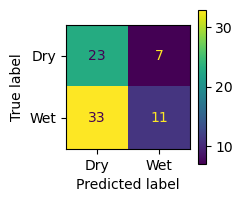


KNeighborsClassifier(n_neighbors=11, weights='distance')
--------------------------------------------
Confusion Matrix: 
 [[17 13]
 [28 16]]

F1 Score: 0.4383561643835616
Recall Score: 0.36363636363636365



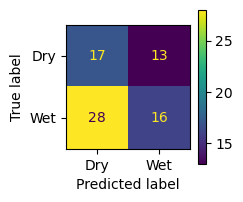


RandomForestClassifier(n_estimators=50, random_state=0)
--------------------------------------------
Confusion Matrix: 
 [[22  8]
 [25 19]]

F1 Score: 0.5352112676056338
Recall Score: 0.4318181818181818



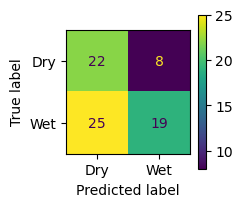


GaussianNB(var_smoothing=2.848035868435805e-09)
--------------------------------------------
Confusion Matrix: 
 [[16 14]
 [17 27]]

F1 Score: 0.6352941176470588
Recall Score: 0.6136363636363636



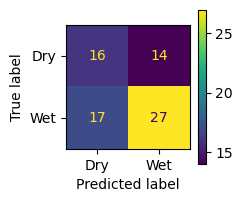

In [1494]:
for model in optimized_models:
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    print()
    print('\033[1m' + str(model) + '\033[0m') 
    print("--------------------------------------------")
    print("Confusion Matrix: \n {}".format(cm))
    print("\nF1 Score: {}".format(f1))
    print("Recall Score: {}\n".format(recall))
    
    display_labels = ['Dry', 'Wet']
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=display_labels)
    fig = disp.figure_
    fig.set_figwidth(2)
    fig.set_figheight(2) 
    plt.show()

## Features

In [1495]:
columns = df_train.columns
print(columns)
print("\033[1mFeatures and Mutual Info Scores\n\033[0m") 


for feature_name in df_train.columns:
    
    try: 
        feature_array = np.array(df_train[feature_name]).reshape(-1,1)
        mutual_info_score = mutual_info_classif(feature_array, y_train)

        print(feature_name, mutual_info_score, "\n")
    
    except:
        continue


mfcc_values = np.asarray(df_train['mfcc'])
mfcc_values = np.vstack((mfcc_values)).T

for i, mfcc_array in enumerate(mfcc_values):
    
    mfcc_array = mfcc_array.reshape(-1,1)
    mutual_info_score = mutual_info_classif(mfcc_array, y_train)

    print(f"mfcc {i+1} {mutual_info_score} \n")

Index(['percentile_25', 'percentile_50', 'percentile_75', 'percentile_90',
       'mfcc', 'sc', 'spectral_bandwidth', 'spectral_contrast',
       'spectral_flatness', 'spectral_rolloff', 'energy', 'duration', 'label'],
      dtype='object')
Features and Mutual Info Scores

percentile_25 [0.090649] 

percentile_50 [0.04148213] 

percentile_75 [0.08171037] 

percentile_90 [0.00533805] 

energy [0.00914925] 

duration [0.13786339] 

mfcc 1 [0] 

mfcc 2 [0] 

mfcc 3 [0] 

mfcc 4 [0.00766636] 

mfcc 5 [0] 

mfcc 6 [0] 

mfcc 7 [0.00825053] 

mfcc 8 [0] 

mfcc 9 [0] 

mfcc 10 [0.0355765] 

mfcc 11 [0.00131101] 

mfcc 12 [0.04369412] 

mfcc 13 [0] 

mfcc 14 [0.02268056] 

mfcc 15 [0.05484178] 

mfcc 16 [0.04985914] 

mfcc 17 [0] 

mfcc 18 [0] 

mfcc 19 [0.00128332] 

mfcc 20 [0] 

mfcc 21 [0] 

mfcc 22 [0.03474901] 

mfcc 23 [0.09956224] 

mfcc 24 [0.03481929] 

mfcc 25 [0.02249049] 

mfcc 26 [0.02321401] 

mfcc 27 [0.0328537] 

mfcc 28 [0.00425523] 

mfcc 29 [0] 

mfcc 30 [0] 

mfcc 31 [0] 
